In [1]:
import seaborn as sns
import os
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score,classification_report
from tensorflow.keras.layers import Dense,Flatten,Conv2D,Dropout,BatchNormalization
from tensorflow.keras.applications.efficientnet import EfficientNetB0
from tensorflow.keras.models import Model
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [2]:
DATA_DIR = 'data'
IMAGE_DIR = f'../{DATA_DIR}/dataset'

image_generator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=False,
    zoom_range=0.1,
    fill_mode='nearest',
    validation_split=0.2
    )

data_train = image_generator.flow_from_directory(
    IMAGE_DIR,
    target_size=(128,128),
    batch_size=256,
    class_mode='categorical',
    shuffle=True,
    subset = 'training'   
)

data_val = image_generator.flow_from_directory(
    IMAGE_DIR,
    target_size=(128,128),
    batch_size=256,
    class_mode='categorical',
    shuffle=True,
    subset = 'validation'   
)

N_CLASSES = data_train.num_classes

Found 4146 images belonging to 5 classes.
Found 1034 images belonging to 5 classes.


In [3]:

IMSIZE = (128,128,3)
INPUT_SIZE = 1000

In [4]:
def finetuned_efficientnet(include_top=False):
    base_model = EfficientNetB0(include_top=include_top,input_shape=IMSIZE,weights='imagenet')
    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = Flatten()(x)
    x = BatchNormalization()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    if not include_top:
        x = Dense(N_CLASSES, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=x)
    model.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['accuracy'])

    return model

In [5]:
efficient_model = finetuned_efficientnet()


2022-07-09 04:13:50.578043: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-09 04:13:50.582892: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-09 04:13:50.583152: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-09 04:13:50.583943: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

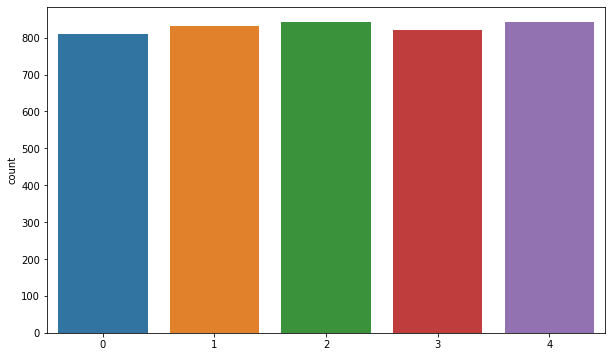

In [6]:
y = data_train.labels

plt.figure("countplot",figsize=(10,6))
sns.countplot(x=y.flatten())
plt.show()

In [8]:
efficient_model.optimizer.learning_rate = 0.001
efficient_model.optimizer.momentum = 0.9
with tf.device('/gpu:0'):
    history = efficient_model.fit_generator(data_train,validation_data=data_val, epochs=500)


/tmp/ipykernel_147653/3581207362.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = efficient_model.fit_generator(data_train,validation_data=data_val, epochs=500)


Epoch 1/500
17/17 [==============================] - 18s 1s/step - loss: 9.3258 - accuracy: 0.2287 - val_loss: 1.7455 - val_accuracy: 0.2002
Epoch 2/500
17/17 [==============================] - 18s 1s/step - loss: 6.2522 - accuracy: 0.2151 - val_loss: 1.6219 - val_accuracy: 0.1954
Epoch 3/500
17/17 [==============================] - 17s 1s/step - loss: 3.3201 - accuracy: 0.2308 - val_loss: 1.6094 - val_accuracy: 0.2002
Epoch 4/500
17/17 [==============================] - 18s 1s/step - loss: 2.2504 - accuracy: 0.2361 - val_loss: 1.6094 - val_accuracy: 0.2002
Epoch 5/500
17/17 [==============================] - 17s 1s/step - loss: 1.8424 - accuracy: 0.2385 - val_loss: 1.6094 - val_accuracy: 0.2002
Epoch 6/500
17/17 [==============================] - 18s 1s/step - loss: 1.7443 - accuracy: 0.2258 - val_loss: 1.6094 - val_accuracy: 0.2002
Epoch 7/500
17/17 [==============================] - 18s 1s/step - loss: 1.6761 - accuracy: 0.2308 - val_loss: 1.6094 - val_accuracy: 0.2031
Epoch 8/500
1

In [ ]:
history.history.keys()


In [ ]:
plt.figure("Model Metrics",(20,10))
plt.title('model accuracy')
plt.subplot(2,1,1)
plt.plot(history.history['loss'])
plt.ylabel('loss')
plt.xlabel('epoch')

plt.subplot(2,1,2)
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.tight_layout()
plt.show()


In [ ]:
plt.figure("Model Metrics",(20,10))
plt.title('model accuracy')
plt.subplot(2,1,1)
plt.plot(history.history['loss'])
plt.ylabel('loss')
plt.xlabel('epoch')

plt.subplot(2,1,2)
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.tight_layout()
plt.show()

In [ ]:
efficient_model.save('../model/saved/efficient_model.h5')